In [1]:
import numpy as np
import pandas as pd
import random
import copy

from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Plots import lens_plot

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 46 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# For source distributions: from redshift get magnitude, sersic radius & ellipticity
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/'
filename = 'source_distributions.csv'
data_dist = pd.read_csv(path + filename)
data_dist = data_dist[data_dist['MAG_PSF_G'] < 30.] [data_dist['MAG_PSF_R'] < 30.] [data_dist['MAG_PSF_I'] < 30.]
data_dist = data_dist[data_dist['SOF_CM_G_1'] > -100.][data_dist['SOF_CM_G_2'] > -100.]
data_dist = data_dist[data_dist['DNF_ZMEAN_SOF'] > 0.01][data_dist['DNF_ZMEAN_SOF'] < 2.9]
data_dist = data_dist.sort_values('DNF_ZMEAN_SOF').reset_index()

dz, dm = 0.1, 0.1 # Range of redshift and magnitude for filtering

#returns magnitude in g, r, i bands and r sersic
def distribution(z, mmax = 25.5, data=data_dist):
    new_data = data[data['DNF_ZMEAN_SOF'] > z - dz] [data['DNF_ZMEAN_SOF'] < z + dz] 
    m = new_data.sample()['MAG_PSF_G'].values[0]
    while(m > mmax):
        m = new_data.sample()['MAG_PSF_G'].values[0]
    new_data = new_data[new_data['MAG_PSF_G'] > m - dm] [new_data['MAG_PSF_G'] < m + dm]
    random_object = new_data.sample()
    mg, mr, mi = random_object['MAG_PSF_G'].values[0], random_object['MAG_PSF_R'].values[0], random_object['MAG_PSF_I'].values[0]
    rg, rr, ri = random_object['FLUX_RADIUS_G'].values[0], random_object['FLUX_RADIUS_R'].values[0], random_object['FLUX_RADIUS_I'].values[0]
    e1, e2 = random_object['SOF_CM_G_1'].values[0], random_object['SOF_CM_G_2'].values[0]
    magnitude = {'mg': mg, 'mr': mr, 'mi': mi}
    radius = {'rg': rg*DES_camera['pixel_scale'], 'rr': rr*DES_camera['pixel_scale'], 'ri': ri*DES_camera['pixel_scale']}
    ellipticity = {'e1': e1, 'e2': e2}
    return(magnitude, radius, ellipticity)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [14]:
z_lens, z_source = 0.1, 0.3
lens_model_list = ['SIE']
lensModel = LensModel(lens_model_list=lens_model_list)

kwargs_model_physical = {'lens_model_list': lens_model_list,  
                          'lens_redshift_list': [z_lens],  # list of redshift of the deflections
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE'],  
                          'source_redshift_list': [z_source],  
                          'cosmo': cosmo, 
                          'z_source': z_source} 

sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)

imSim_g = sim_g.image_model_class(kwargs_numerics)
imSim_r = sim_r.image_model_class(kwargs_numerics)
imSim_i = sim_i.image_model_class(kwargs_numerics)

kwargs_mass = [{'sigma_v': 350, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}]
kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)

mag1, rad1, ellip1 = distribution(z_source)
n1 = random.uniform(0.3, 4.)
kwargs_source_mag_g = [{'magnitude': mag1['mg'], 'R_sersic': rad1['rg'], 'n_sersic': n1,
                              'e1': ellip1['e1'], 'e2': ellip1['e2'], 'center_x': 0, 'center_y': 0}]

#Adding color distribution to the bands (first source):
kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'], kwargs_source_mag_r[0]['R_sersic'] = mag1['mr'], rad1['rr']
kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'], kwargs_source_mag_i[0]['R_sersic'] = mag1['mi'], rad1['ri']

kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)

image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
image_g += sim_g.noise_for_model(model=image_g)
image_r += sim_r.noise_for_model(model=image_r)
image_i += sim_i.noise_for_model(model=image_i)
    
image_g = image_g[::-1]
image_r = image_r[::-1]
image_i = image_i[::-1]

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [19]:
lensModelExt = LensModelExtensions(lensModel)
ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = lensModelExt.critical_curve_caustics(kwargs_lens, 
                                                                compute_window=10, grid_scale=0.01, center_x=0, center_y=0)
ra_crit_list, dec_crit_list = ra_crit_list[0], dec_crit_list[0]
ra_caustic_list, dec_caustic_list = ra_caustic_list[0], dec_caustic_list[0]

In [20]:
print(len(ra_caustic_list), len(dec_caustic_list))
print(min(ra_caustic_list), min(dec_caustic_list))
print(max(ra_caustic_list), max(dec_caustic_list))
print(min(ra_crit_list), min(dec_crit_list))
print(max(ra_crit_list), max(dec_crit_list))

1865 1865
-0.43708267840509185 -0.368375974876328
0.43708266289956077 0.36837598980520925
-2.5608123486272034 -2.0994570909496755
2.5608167057133437 2.0994565328997146


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


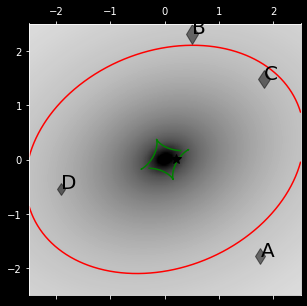

In [21]:
beta_ra, beta_dec = 0.2, 0.

f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

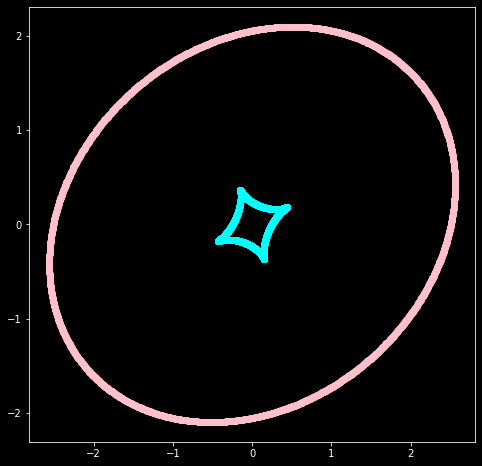

In [22]:
#make my own plot with the coordinates of the caustic (scatter)
plt.figure(figsize=(8,8))
plt.plot(ra_caustic_list, dec_caustic_list, 'o', color='cyan')
plt.plot(ra_crit_list, dec_crit_list, 'o', color='pink')
plt.show()